In [2]:
!nvidia-smi

Tue Nov  4 16:11:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 573.22                 Driver Version: 573.22         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              2W /   60W |     177MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
%pip install -q --index-url https://download.pytorch.org/whl/cu118 torchvision
%pip install -q "numpy>=2.2" "scipy>=1.15" "scikit-learn>=1.5" "matplotlib>=3.8" pillow
%pip install -q --no-deps timm==0.9.16 albumentations==2.0.8

import torch, numpy, sklearn, platform
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available(), "| CUDA wheel:", torch.version.cuda)
print("NumPy:", numpy.__version__, "| scikit-learn:", sklearn.__version__)
print("Python:", platform.python_version(), "| OS:", platform.system())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Torch: 2.7.1+cu118
CUDA available: True | CUDA wheel: 11.8
NumPy: 2.3.4 | scikit-learn: 1.6.1
Python: 3.13.5 | OS: Windows
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [ ]:
import os, random
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (confusion_matrix, classification_report)

import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

plt.rcParams["figure.dpi"] = 130

In [25]:
CFG = {
    "seed": 42,
    "root": r"C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-learning---egg-detection\Dataset\Eggs Classification",
    "img_size": 384,
    "batch_size": 8,
    "epochs": 5,
    "num_workers": 0,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "model_name": "tf_efficientnetv2_s",
    "labels": ["Damaged", "Not Damaged"],
    "save_path": "./egg_cls_best.pt",
    "patience": 3
}

def set_seed(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG["seed"])
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [16]:
def list_images(root):
    rows = []
    classes = ["Damaged","Not Damaged"]
    for y, sub in enumerate(classes):
        p = Path(root) / sub
        exts = (".jpg")
        files = [str(fp) for fp in p.rglob("*") if fp.suffix.lower() in exts]
        for f in files:
            rows.append((f, y, sub))
    return pd.DataFrame(rows, columns=["path","label","label_name"])

df = list_images(CFG["root"])
print(df.head())
print("Counts by class:\n", df["label_name"].value_counts())

# Stratified split: 70% train, 15% val, 15% test
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=CFG["seed"])
train_idx, temp_idx = next(sss1.split(df['path'], df['label']))
df_train = df.iloc[train_idx].reset_index(drop=True)
df_temp  = df.iloc[temp_idx].reset_index(drop=True)

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=CFG["seed"])
val_idx, test_idx = next(sss2.split(df_temp['path'], df_temp['label']))
df_val  = df_temp.iloc[val_idx].reset_index(drop=True)
df_test = df_temp.iloc[test_idx].reset_index(drop=True)

print(f"Split sizes -> train={len(df_train)} val={len(df_val)} test={len(df_test)}")

                                                path  label label_name
0  C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-...      0    Damaged
1  C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-...      0    Damaged
2  C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-...      0    Damaged
3  C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-...      0    Damaged
4  C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-...      0    Damaged
Counts by class:
 label_name
Damaged        632
Not Damaged    162
Name: count, dtype: int64
Split sizes -> train=555 val=119 test=120


In [ ]:
IMG_SIZE = CFG["img_size"]
train_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0, value=0),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(), ToTensorV2()
])
valid_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0, value=0),
    A.Normalize(), ToTensorV2()
])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15420\238841767.py:4: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0, value=0),
c:\Users\ADMIN\anaconda3\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15420\238841767.py:12: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0, value=0),


In [18]:
class EggsDS(Dataset):
    def __init__(self, df, aug):
        self.df = df.reset_index(drop=True)
        self.aug = aug
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.path).convert("RGB")
        x = self.aug(image=np.array(img))["image"]
        y = torch.tensor(row.label).long()
        return x, y

train_ds = EggsDS(df_train, train_tfms)
val_ds   = EggsDS(df_val,   valid_tfms)
test_ds  = EggsDS(df_test,  valid_tfms)

def make_loader(ds, train=False):
    return DataLoader(
        ds, batch_size=CFG["batch_size"], shuffle=train,
        num_workers=CFG["num_workers"], pin_memory=True, drop_last=train
    )

train_loader = make_loader(train_ds, train=True)
val_loader   = make_loader(val_ds)
test_loader  = make_loader(test_ds)

In [19]:
counts = df_train['label'].value_counts().sort_index().values.astype(float)
class_weights = (counts.sum() / (len(counts) * counts))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights.tolist())

model = timm.create_model(CFG["model_name"], pretrained=True, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])


Class weights: [0.627828061580658, 2.45575213432312]


In [22]:
def run_one_epoch(loader, train_mode=True):
    model.train(train_mode)
    total_loss, correct, total = 0.0, 0, 0
    all_probs, all_targets = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train_mode:
            optimizer.zero_grad()
        out = model(x)                 
        loss = criterion(out, y)
        if train_mode:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

        probs = torch.softmax(out, dim=1)[:,1].detach().cpu().numpy()
        all_probs.append(probs)
        all_targets.append(y.detach().cpu().numpy())

    avg_loss = total_loss / total
    acc = correct / total
    y_true = np.concatenate(all_targets)
    y_prob  = np.concatenate(all_probs)
    return avg_loss, acc, y_true, y_prob

In [23]:
best_val_loss = float("inf")
best_state = None
patience = CFG["patience"]

for epoch in range(1, CFG["epochs"]+1):
    tr_loss, tr_acc, _, _ = run_one_epoch(train_loader, train_mode=True)
    va_loss, va_acc, _, _ = run_one_epoch(val_loader,   train_mode=False)
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} "
          f"| val_loss={va_loss:.4f} acc={va_acc:.4f}")

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience = CFG["patience"]
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping.")
            break

# Lưu & nạp lại best
torch.save(best_state, CFG["save_path"])
print("Saved best to:", CFG["save_path"])
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

Epoch 01 | train_loss=1.1654 acc=0.8714 | val_loss=0.1660 acc=0.9160
Epoch 02 | train_loss=0.7449 acc=0.9094 | val_loss=0.1010 acc=0.9412
Epoch 03 | train_loss=0.1356 acc=0.9620 | val_loss=0.0498 acc=0.9832
Epoch 04 | train_loss=0.0202 acc=0.9928 | val_loss=0.0245 acc=0.9916
Epoch 05 | train_loss=0.0452 acc=0.9873 | val_loss=0.0511 acc=0.9832
Epoch 06 | train_loss=0.0087 acc=0.9982 | val_loss=0.0309 acc=0.9916
Epoch 07 | train_loss=0.0171 acc=0.9946 | val_loss=0.0630 acc=0.9748
Epoch 08 | train_loss=0.0102 acc=0.9946 | val_loss=0.1264 acc=0.9664
Early stopping.
Saved best to: ./egg_cls_best.pt


<All keys matched successfully>


=== Test report ===
              precision    recall  f1-score   support

     Damaged     1.0000    0.9684    0.9840        95
 Not Damaged     0.8929    1.0000    0.9434        25

    accuracy                         0.9750       120
   macro avg     0.9464    0.9842    0.9637       120
weighted avg     0.9777    0.9750    0.9755       120

Confusion matrix:
 [[92  3]
 [ 0 25]]


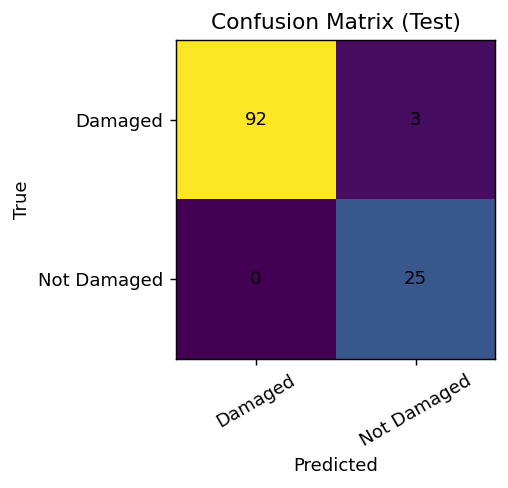

In [26]:
_, _, te_y, te_prob = run_one_epoch(test_loader, train_mode=False)
te_pred = (te_prob >= 0.5).astype(int)  # ngưỡng 0.5 cho đơn giản

print("\n=== Test report ===")
print(classification_report(te_y, te_pred, target_names=CFG["labels"], digits=4))
cm = confusion_matrix(te_y, te_pred)
print("Confusion matrix:\n", cm)

# Vẽ confusion matrix (cho dễ nhìn)
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Test)")
ax.set_xticks([0,1]); ax.set_xticklabels(CFG["labels"], rotation=30)
ax.set_yticks([0,1]); ax.set_yticklabels(CFG["labels"])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()


In [40]:
@torch.no_grad()
def predict_paths(paths, thr=0.5, bs=8):
    import pandas as _pd  # <--- thêm dòng này để tránh 'pd' bị ghi đè ở global
    if isinstance(paths, (str, Path)):  # chấp nhận string/path đơn lẻ
        paths = [str(paths)]
    else:
        paths = [str(p) for p in paths]

    if len(paths) == 0:
        return np.array([]), np.array([])

    tmp = _pd.DataFrame({"path": paths, "label": [0]*len(paths)})
    ds = EggsDS(tmp, valid_tfms)
    dl = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0,
                    pin_memory=torch.cuda.is_available())

    model.eval()
    probs = []
    for x, _ in dl:
        x = x.to(device)
        logits = model(x)
        probs.append(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())

    probs = np.concatenate(probs) if probs else np.array([])
    preds = (probs >= thr).astype(int) if probs.size else np.array([], dtype=int)
    return probs, preds

In [45]:
from pathlib import Path

# ---- Nhập đường dẫn: có thể là FILE hoặc FOLDER ----
inp = r"C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-learning---egg-detection\Model\hqminh\377416300_972505850709214_5913823485606979062_n.jpg"

exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
p = Path(inp)

# Chẩn đoán nhanh
print("Input path :", p)
print("Resolved   :", p.resolve())
print("Exists?    :", p.exists())
print("is_file?   :", p.is_file())
print("is_dir?    :", p.is_dir())

# ---- Gom danh sách ảnh ----
sample_paths = []
if p.is_file():
    if p.suffix.lower() in exts:
        sample_paths = [str(p)]
    else:
        print("File không phải ảnh hợp lệ theo exts:", exts)
elif p.is_dir():
    sample_paths = [str(fp) for fp in p.rglob("*") if fp.suffix.lower() in exts]
else:
    # Thử hiểu đây là đường dẫn tương đối sai gốc -> gợi ý đổi sang tuyệt đối
    print("⚠️ Đường dẫn không tồn tại. Hãy thử dùng đường dẫn tuyệt đối.")

print("Found", len(sample_paths), "image(s)")

# --- Dự đoán ---
if sample_paths:
    probs, preds = predict_paths(sample_paths, thr=0.5)
    for pth, pr, pd in zip(sample_paths, probs, preds):
        print(f"{Path(pth).name:25s} -> {CFG['labels'][pd]} (p={pr:.3f})")


Input path : C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-learning---egg-detection\Model\hqminh\377416300_972505850709214_5913823485606979062_n.jpg
Resolved   : C:\Users\ADMIN\OneDrive\Desktop\eggclass\Deep-learning---egg-detection\Model\hqminh\377416300_972505850709214_5913823485606979062_n.jpg
Exists?    : True
is_file?   : True
is_dir?    : False
Found 1 image(s)
377416300_972505850709214_5913823485606979062_n.jpg -> Not Damaged (p=1.000)
